In [75]:
#!/usr/bin/python
# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from redTools import *
from Kcorrect import *
################################################################# 
def add_axis(ax, xlim, ylim):
    
    x1, x2 = xlim[0], xlim[1]
    y1, y2 = ylim[0], ylim[1]
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    ax.minorticks_on()
    ax.tick_params(which='major', length=5, width=1.0)
    ax.tick_params(which='minor', length=2, color='#000033', width=1.0)     
    
    # additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(y1, y2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=5, width=1.0, direction='in')
    y_ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')

    # additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(x1, x2)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=5, width=1.0, direction='in')
    x_ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')
    

########################################################### Begin

inFile  = 'ESN_HI_catal.csv'
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

table = extinctionCorrect(table)
table = Kcorrection(table)

index, = np.where(table['Sba']>0.01)
table = trim(table, index)

index, = np.where(table['Wba']>0.01)
table = trim(table, index)

Sba = table['Sba']
Wba = table['Wba']


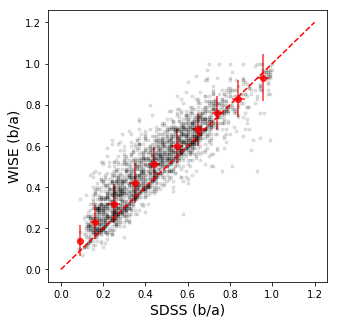

In [76]:
fig = plt.figure(figsize=(5, 5))
plt.plot(Sba,Wba, 'k.', alpha=0.1)
plt.plot([0,1.2],[0,1.2], 'r--')
plt.xlabel('SDSS (b/a)', size=14)
plt.ylabel('WISE (b/a)', size=14)


for i in np.arange(0,1,0.1):
    
    x = []
    y = []
    for ii in range(len(Sba)):
        xi = Sba[ii]
        if xi>=i and xi<i+0.1:
            x.append(xi)
            y.append(Wba[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)


In [77]:
from astropy.stats import sigma_clip

def sigmaClip(Sba, Wba, sigma=2, iters=5, range_=[0,1,0.05]):
    x_ = []
    y_ = []

    x_ = np.asarray(x_)
    y_ = np.asarray(y_)
    
    a = range_[0]
    b = range_[1]
    d = range_[2]

    for i in np.arange(a,b,d):

        x = []
        y = []
        for ii in range(len(Sba)):
            xi = Sba[ii]
            if xi>=i and xi<i+d:
                x.append(xi)
                y.append(Wba[ii])
        if len(x)>0:
            y = np.asarray(y)
            x = np.asarray(x)
            filtered_data = sigma_clip(y, sigma=sigma, iters=iters, copy=False)
            y = filtered_data.data[np.logical_not(filtered_data.mask)]
            x = x[np.logical_not(filtered_data.mask)]

            x_ = np.concatenate((x_, x))
            y_ = np.concatenate((y_, y))
    return x_, y_


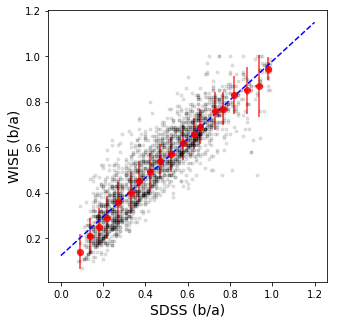

In [78]:
Sba, Wba = sigmaClip(Sba, Wba, sigma=4, iters=5)

fig = plt.figure(figsize=(5, 5))
plt.plot(Sba,Wba, 'k.', alpha=0.1)
#plt.plot([0,1.2],[0,1.2], 'r--')
plt.xlabel('SDSS (b/a)', size=14)
plt.ylabel('WISE (b/a)', size=14)


for i in np.arange(0,1,0.05):
    
    x = []
    y = []
    for ii in range(len(Sba)):
        xi = Sba[ii]
        if xi>=i and xi<i+0.05:
            x.append(xi)
            y.append(Wba[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

############################################# Geting rid of outliers
a0, b0  = np.polyfit(Sba, Wba, 1)
x = np.linspace(0,1.2,50)
y = a0*x+b0
plt.plot(x, y, 'b--')
#############################################

Text(0,0.5,'$R_e$ WISE [arcmin]')

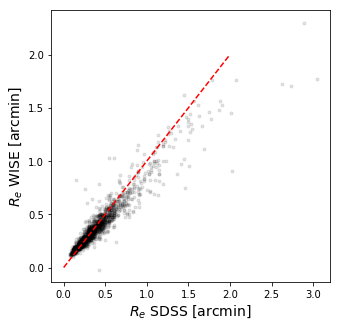

In [94]:
#Ri = (table['R50_w1']+table['R50_w2'])/2.
Ri = table['R50_w1']
#Ro = (table['R50_g']+table['R50_r']+table['R50_i'])/3.
Ro = table['R50_i']
      
fig = plt.figure(figsize=(5, 5))
plt.plot(Ro,Ri, 'k.', alpha=0.1)
plt.plot([0,2],[0,2], 'r--')
plt.xlabel('$R_e$'+' SDSS [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE [arcmin]', size=14)

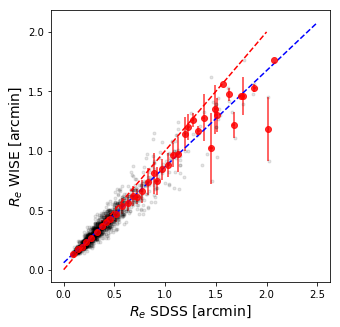

In [95]:
Ro, Ri = sigmaClip(Ro, Ri, sigma=3, iters=5, range_=[0,2.5,0.1])

fig = plt.figure(figsize=(5, 5))
plt.plot(Ro,Ri, 'k.', alpha=0.1)
plt.plot([0,2],[0,2], 'r--')
plt.xlabel('$R_e$'+' SDSS [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE [arcmin]', size=14)

for i in np.arange(0,2.5,0.05):
    
    x = []
    y = []
    for ii in range(len(Ro)):
        xi = Ro[ii]
        if xi>=i and xi<i+0.05:
            x.append(xi)
            y.append(Ri[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

############################################# Geting rid of outliers
a0, b0  = np.polyfit(Ro, Ri, 1)
x = np.linspace(0,2.5,50)
y = a0*x+b0
plt.plot(x, y, 'b--')
#############################################